In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM10_sensor_and_council.csv')
data.head()

,Datetime,PM10_µg/m³_dust_pollen_mould_spores_sensor,PM10_µg/m³_council
0,2024-08-15 15:00:00,5.833333,17.0
1,2024-08-15 16:00:00,4.766667,14.8
2,2024-08-15 17:00:00,3.816667,18.1
3,2024-08-15 18:00:00,6.083333,14.4
4,2024-08-15 19:00:00,6.105263,0.3


In [3]:
X = data[['PM10_µg/m³_dust_pollen_mould_spores_sensor']].values
y = data['PM10_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[21.96610169],
       [10.35      ],
       [11.13333333],
       [ 9.33333333],
       [ 6.625     ]])

array([[ 1.24079012],
       [-0.00136591],
       [ 0.08239904],
       [-0.11008213],
       [-0.399695  ]])

array([[12.05      ],
       [ 7.        ],
       [ 4.66666667],
       [ 7.95      ],
       [ 8.        ]])

array([[ 0.18042186],
       [-0.35959476],
       [-0.60910739],
       [-0.25800747],
       [-0.25266077]])

#### Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'adaboost__learning_rate': 0.001, 'adaboost__loss': 'linear', 'adaboost__n_estimators': 150}
Test RMSE: 5.3476
Test MSE: 28.5969
Test R2: 0.2203
Test MAE: 4.0690


,Actual,Predicted
0,9.7,11.808333
1,11.2,13.688889
2,12.0,13.827273
3,8.7,15.331250
4,21.1,15.331250
5,5.2,11.808333
6,0.3,14.300000
7,12.5,12.052941
8,11.5,15.728571
9,14.4,14.300000


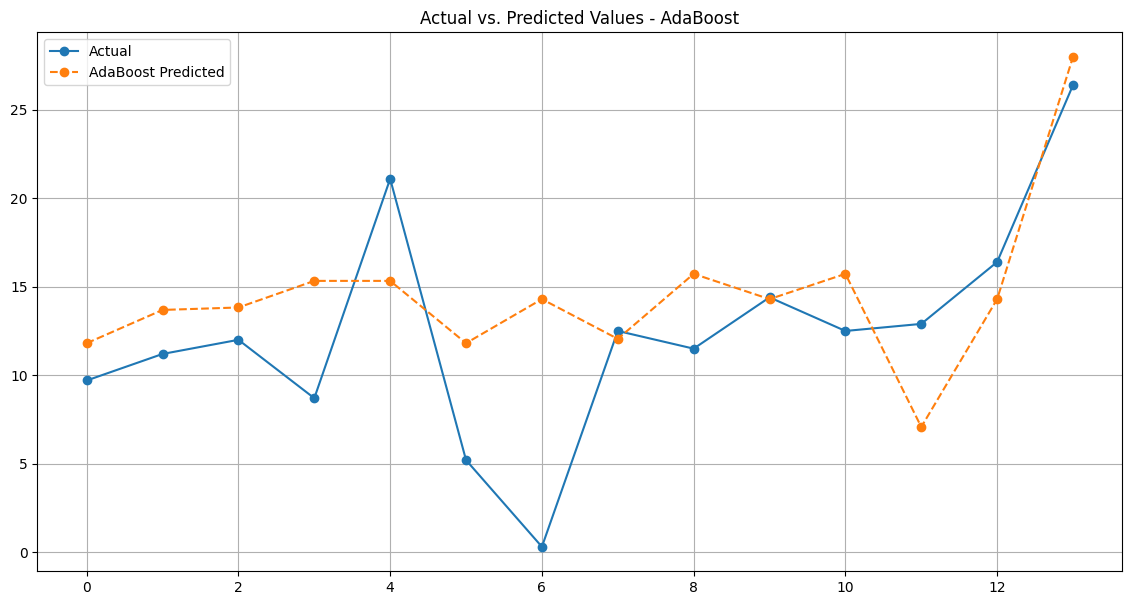


Results For Model: AdaBoost
Best Hyperparameters: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200, 'xgboost__subsample': 0.6}
Test RMSE: 5.4607
Test MSE: 29.8188
Test R2: 0.1870
Test MAE: 4.0577


,Actual,Predicted
0,9.7,12.898978
1,11.2,12.424131
2,12.0,10.756186
3,8.7,14.992061
4,21.1,14.992061
5,5.2,14.788573
6,0.3,13.412568
7,12.5,11.982964
8,11.5,17.300282
9,14.4,13.412568


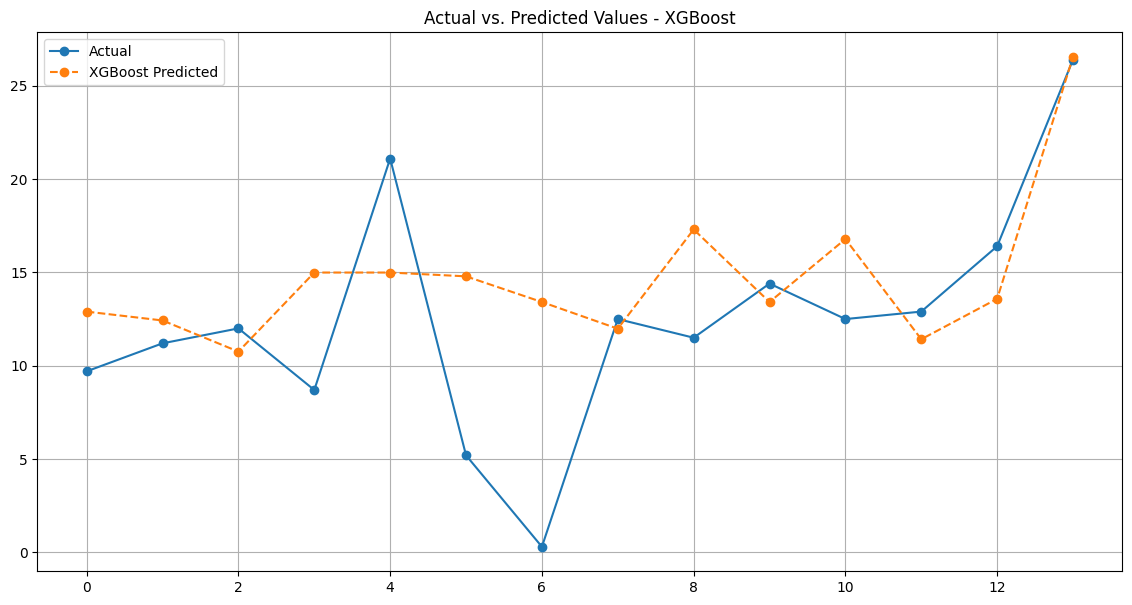


Results For Model: XGBoost
Best Hyperparameters: {'gradientboosting__learning_rate': 0.01, 'gradientboosting__max_depth': 3, 'gradientboosting__n_estimators': 200}
Test RMSE: 5.5352
Test MSE: 30.6381
Test R2: 0.1647
Test MAE: 4.4077


,Actual,Predicted
0,9.7,13.387313
1,11.2,12.642731
2,12.0,13.226379
3,8.7,14.337260
4,21.1,14.337260
5,5.2,13.387313
6,0.3,13.226379
7,12.5,12.578116
8,11.5,17.219487
9,14.4,13.226379


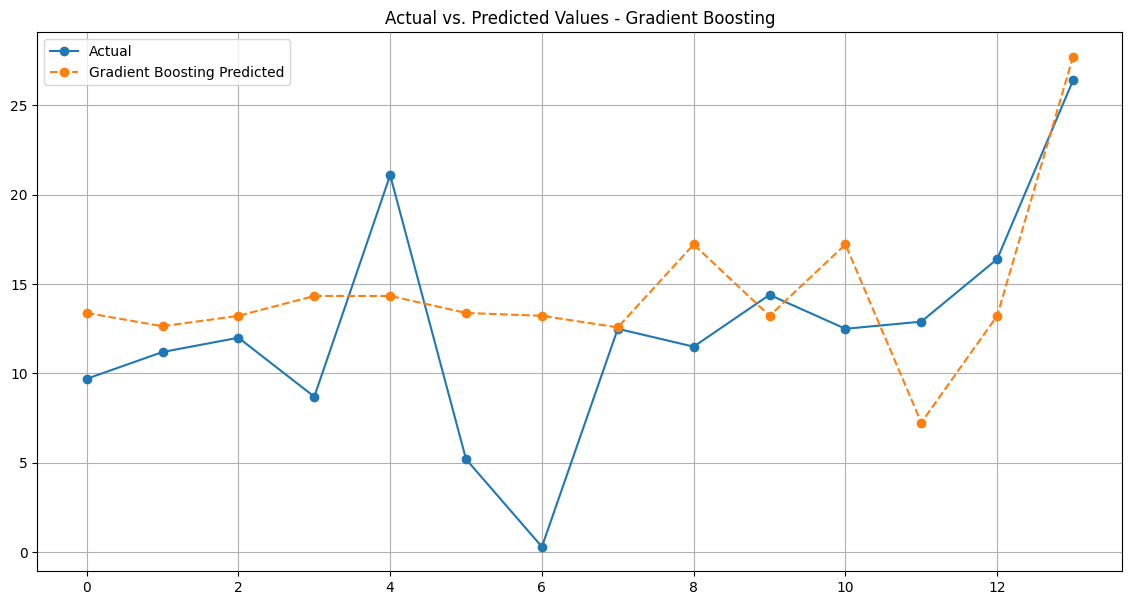


Results For Model: Gradient Boosting
Best Hyperparameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
Test RMSE: 5.7663
Test MSE: 33.2502
Test R2: 0.0935
Test MAE: 4.4239


,Actual,Predicted
0,9.7,16.129558
1,11.2,13.105942
2,12.0,11.708892
3,8.7,13.674741
4,21.1,13.704678
5,5.2,17.207282
6,0.3,12.570231
7,12.5,15.141644
8,11.5,14.592803
9,14.4,12.557101


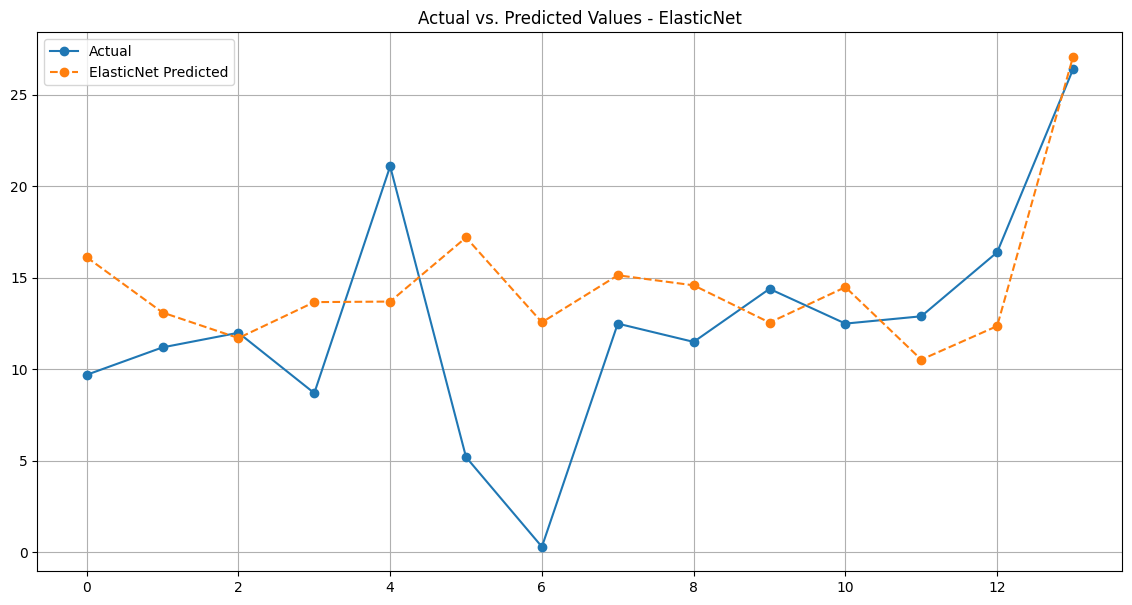


Results For Model: ElasticNet
Best Hyperparameters: {'poly__degree': 1}
Test RMSE: 5.8144
Test MSE: 33.8073
Test R2: 0.0783
Test MAE: 4.5724


,Actual,Predicted
0,9.7,16.222280
1,11.2,12.921139
2,12.0,11.395859
3,8.7,13.542146
4,21.1,13.574830
5,5.2,17.398925
6,0.3,12.336257
7,12.5,15.143690
8,11.5,14.544473
9,14.4,12.321922


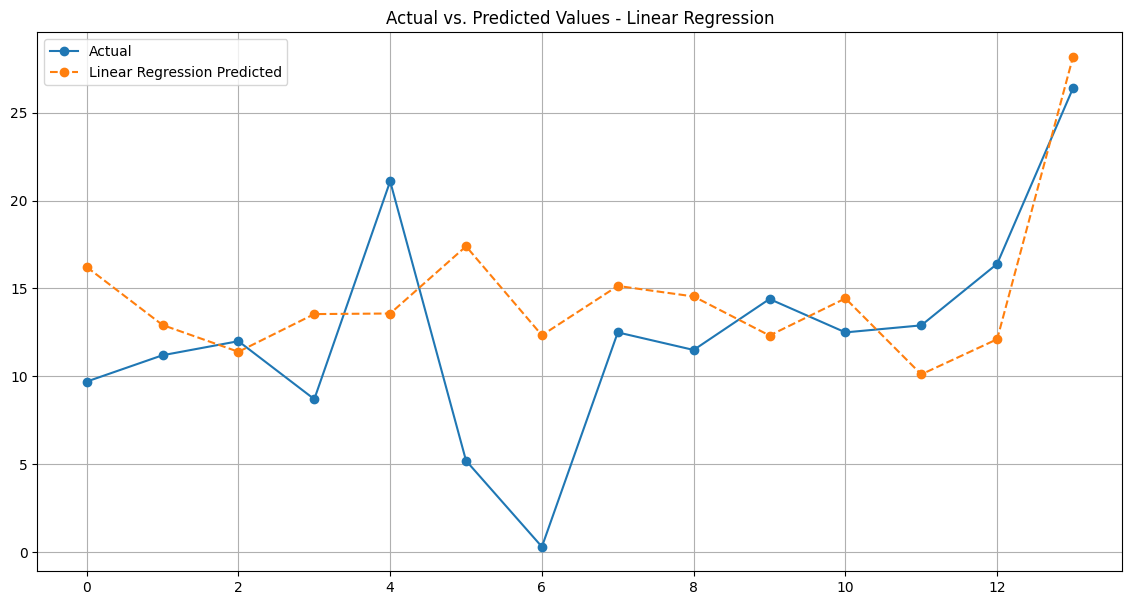


Results For Model: Linear Regression
Best Hyperparameters: {'poly__degree': 3, 'ridge__alpha': 0.1}
Test RMSE: 5.8420
Test MSE: 34.1293
Test R2: 0.0695
Test MAE: 4.6239


,Actual,Predicted
0,9.7,15.827414
1,11.2,12.402091
2,12.0,11.263337
3,8.7,12.954927
4,21.1,12.985338
5,5.2,17.287848
6,0.3,11.926977
7,12.5,14.585904
8,11.5,13.943453
9,14.4,11.915913


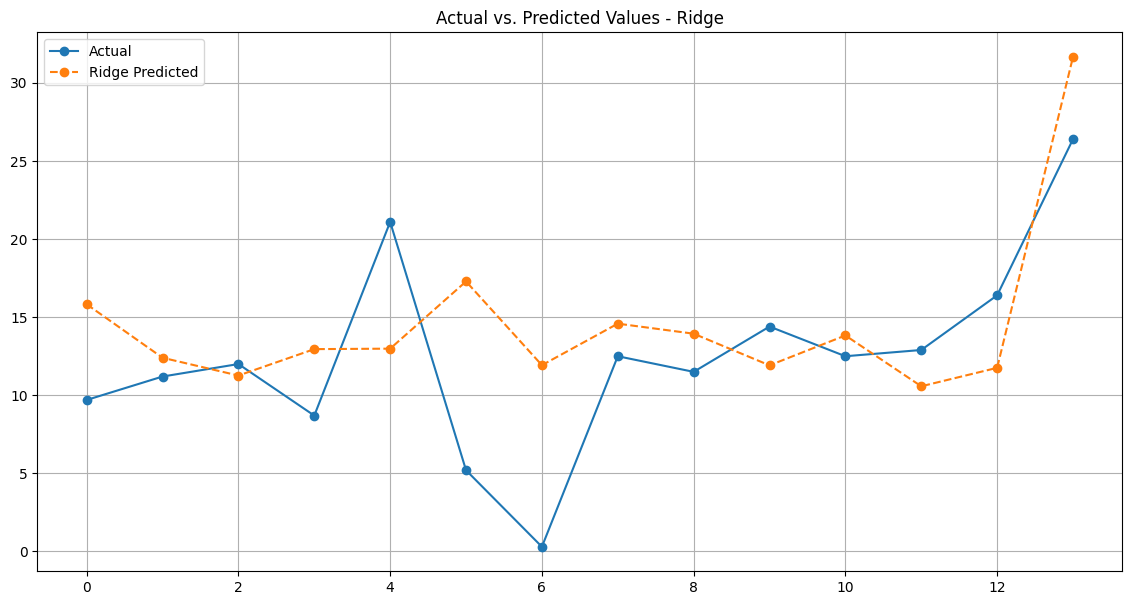


Results For Model: Ridge
Best Hyperparameters: {'lasso__alpha': 0.01, 'poly__degree': 3}
Test RMSE: 5.8520
Test MSE: 34.2453
Test R2: 0.0663
Test MAE: 4.6382


,Actual,Predicted
0,9.7,15.858355
1,11.2,12.405909
2,12.0,11.245539
3,8.7,12.965789
4,21.1,12.996545
5,5.2,17.322949
6,0.3,11.923252
7,12.5,14.610659
8,11.5,13.963701
9,14.4,11.911992


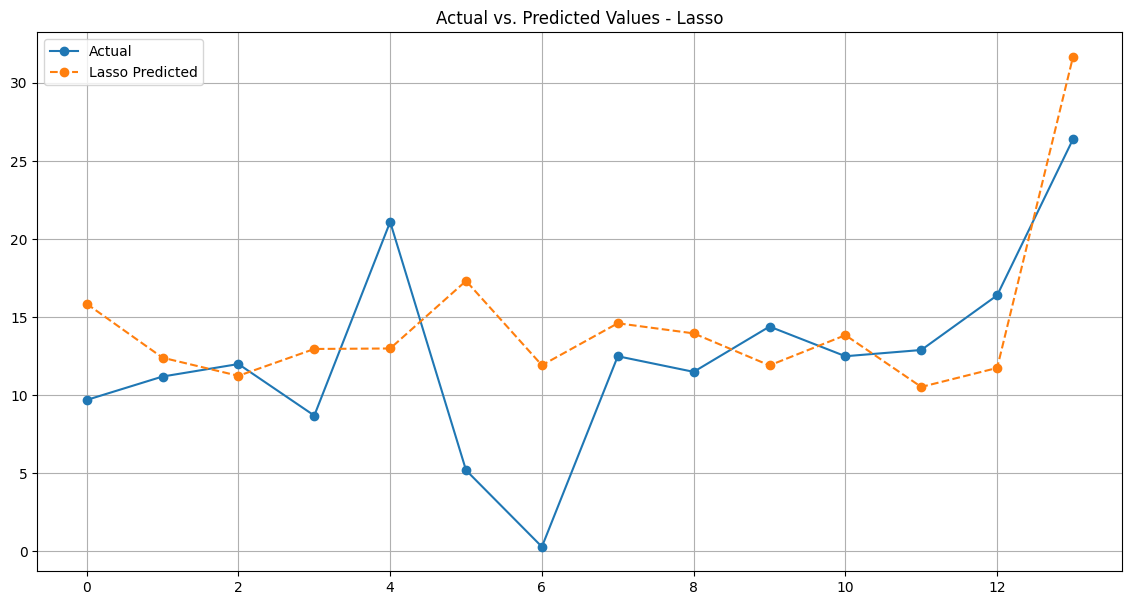


Results For Model: Lasso
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 150}
Test RMSE: 5.9628
Test MSE: 35.5548
Test R2: 0.0306
Test MAE: 4.5500


,Actual,Predicted
0,9.7,11.974516
1,11.2,11.038099
2,12.0,12.151879
3,8.7,14.674913
4,21.1,14.674913
5,5.2,11.974516
6,0.3,13.685025
7,12.5,12.511095
8,11.5,19.039809
9,14.4,13.685025


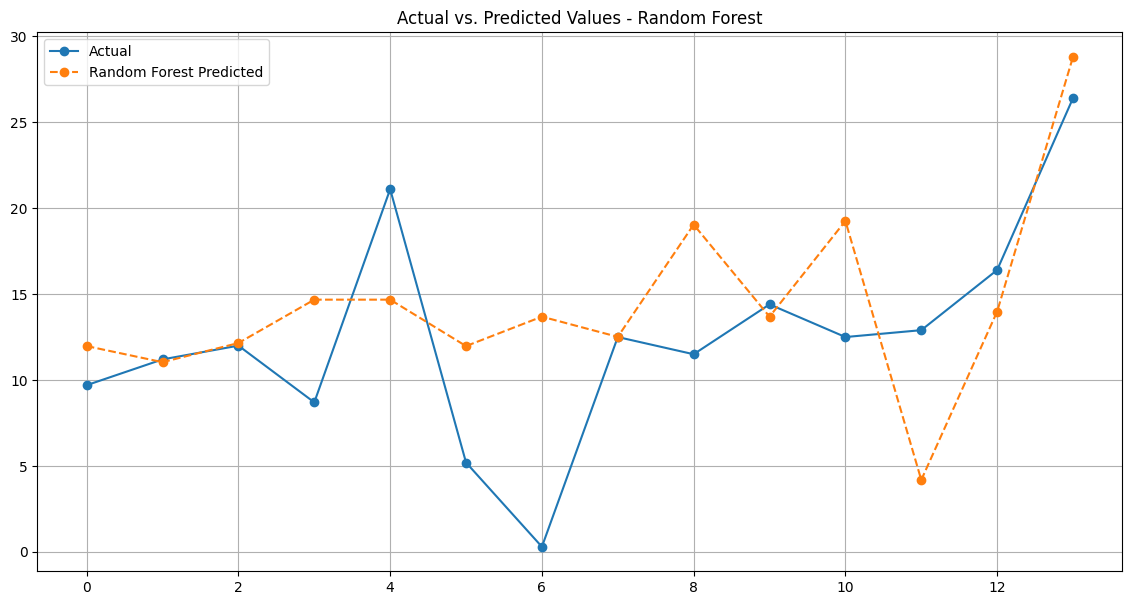


Results For Model: Random Forest
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 3, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'distance'}
Test RMSE: 6.0706
Test MSE: 36.8523
Test R2: -0.0047
Test MAE: 4.7187


,Actual,Predicted
0,9.7,12.439665
1,11.2,10.418293
2,12.0,13.940574
3,8.7,14.100000
4,21.1,15.244615
5,5.2,11.303149
6,0.3,13.417846
7,12.5,11.876923
8,11.5,20.159033
9,14.4,13.641008


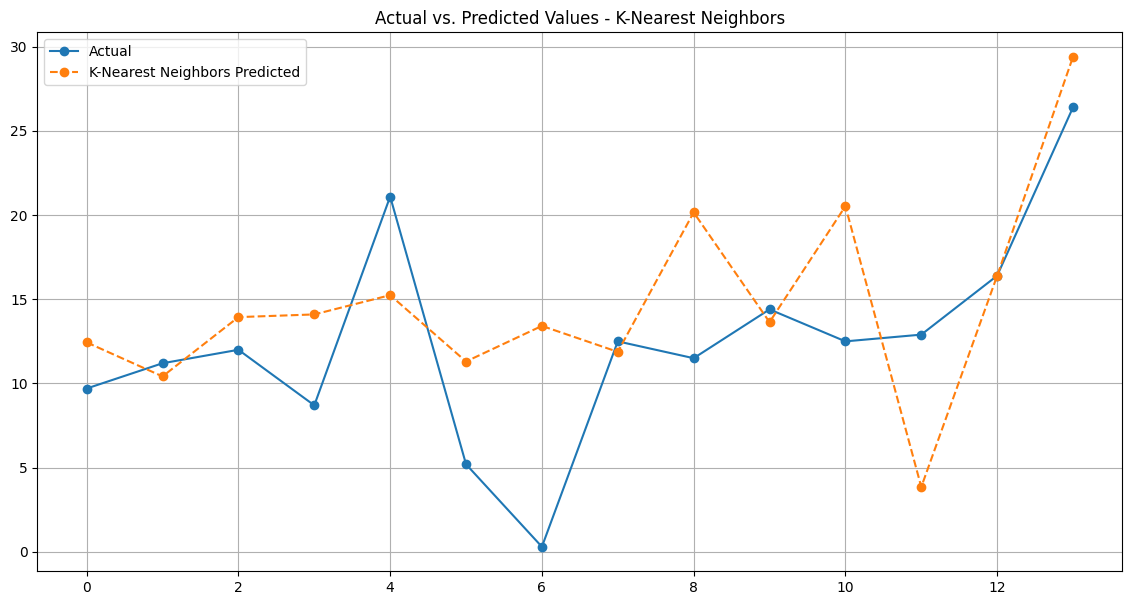

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,AdaBoost,5.347611,28.596942,0.220332,4.068972
1,XGBoost,5.460662,29.818830,0.187019,4.057749
2,Gradient Boosting,5.535171,30.638116,0.164682,4.407704
3,ElasticNet,5.766297,33.250185,0.093466,4.423890
4,Linear Regression,5.814404,33.807295,0.078277,4.572432
5,Ridge,5.842032,34.129339,0.069497,4.623881
6,Lasso,5.851951,34.245325,0.066335,4.638175
7,Random Forest,5.962787,35.554827,0.030632,4.549975
8,K-Nearest Neighbors,6.070611,36.852313,-0.004742,4.718741
